# Experimental study for the article
## Kirill Zakharov
2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp
import scipy.stats as sts
from tqdm import tqdm
from sdv.metadata import SingleTableMetadata

from TRGAN.TRGAN_main import *
import TRGAN.Privacy_modules as privacy_trgan
from TRGAN.encoders import *
import TRGAN.TRGAN_train_load_modules as trgan_train
from TRGAN.evaluation_metrics import *
from TRGAN.methods_comparison import *
from TRGAN.dpgan import *
from train import train_all_models

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [2]:
import matplotlib as mpl
#set params for the article
# mpl.rcParams['xtick.labelsize'] = 16
# mpl.rcParams['ytick.labelsize'] = 16
# mpl.rcParams['legend.fontsize'] = 14
# mpl.rcParams['axes.labelsize'] = 18

#set params for the notebook
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['axes.labelsize'] = 14

In [3]:
data, synth_df, synth_df_rdp, synth_df_ae, synth_df_dpgan, synth_df_trgan_dpgan, synth_df_pategan = train_all_models(load=False, experiment_id='Privacy_RAIF_2_eps=0.5')

  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (5, 0.1)-Differential Privacy


Loss E_oh: 5.542875533559588e-11 || Privacy Loss E_oh: 0.013647045008838177: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]  
  0%|          | 0/20 [00:00<?, ?it/s]

E_cl with (0.01, 0.1)-Differential Privacy


Loss E_cl: 5.339708764040552e-07 || Privacy Loss E_cl: 0.507098913192749: 100%|██████████| 20/20 [00:42<00:00,  2.12s/it]   


E_cv with (0.01, 0.1)-Differential Privacy


Loss E_cv: 0.000092855 || Privacy Loss E_cv: 0.084764495: 100%|██████████| 15/15 [00:32<00:00,  2.16s/it] 
Discriminator Loss: -0.00440 || Discriminator 2 Loss: -0.00483 || Generator Loss: -0.00841 || Supervisor Loss: -0.00599: 100%|██████████| 30/30 [05:38<00:00, 11.28s/it]


TRGAN with (0.3155519726287818, 0.1)-differential privacy


Discriminator Loss: -0.00073 || Discriminator 2 Loss: -0.00038 || Generator Loss: 0.00923 || Supervisor Loss: 0.01209: 100%|██████████| 30/30 [03:12<00:00,  6.42s/it]
  0%|          | 0/30 [00:00<?, ?it/s]

TRGAN with (0.5, 0.1)-differential privacy


Discriminator Loss: -0.00050 || Discriminator 2 Loss: -0.00643 || Generator Loss: 0.00498 || Supervisor Loss: -0.00577: 100%|██████████| 30/30 [04:04<00:00,  8.15s/it]
Discriminator Loss: -0.00112 || Discriminator 2 Loss: -0.00135 || Generator Loss: 0.00819 || Supervisor Loss: -0.00901: 100%|██████████| 30/30 [05:56<00:00, 11.89s/it]


TRGAN with (0.31596858456647237, 0.1)-differential privacy


Discriminator Loss: -0.00018 || Discriminator 2 Loss: -0.00034 || Generator Loss: 0.00952 || Supervisor Loss: 0.01283: 100%|██████████| 30/30 [03:24<00:00,  6.82s/it]
  0%|          | 0/30 [00:00<?, ?it/s]

TRGAN with (0.5, 0.1)-differential privacy


Discriminator Loss: -0.00194 || Discriminator 2 Loss: -0.00446 || Generator Loss: -0.00499 || Supervisor Loss: 0.01069: 100%|██████████| 30/30 [04:07<00:00,  8.24s/it]
  0%|          | 0/30 [00:00<?, ?it/s]

TRGAN with (0.5, 0.1)-differential privacy


Discriminator Loss: 0.00021 || Generator Loss: 0.01000: 100%|██████████| 30/30 [01:08<00:00,  2.29s/it]
  0%|          | 0/30 [00:00<?, ?it/s]

TRGAN with (0.5, 0.1)-differential privacy


Discriminator Loss: -0.00172 || Discriminator 2 Loss: -0.00023 || Generator Loss: -0.00999 || Supervisor Loss: -0.00777: 100%|██████████| 30/30 [03:35<00:00,  7.18s/it]
Student Loss: nan || Generator Loss: -0.68187: 100%|██████████| 30/30 [03:40<00:00,  7.35s/it]


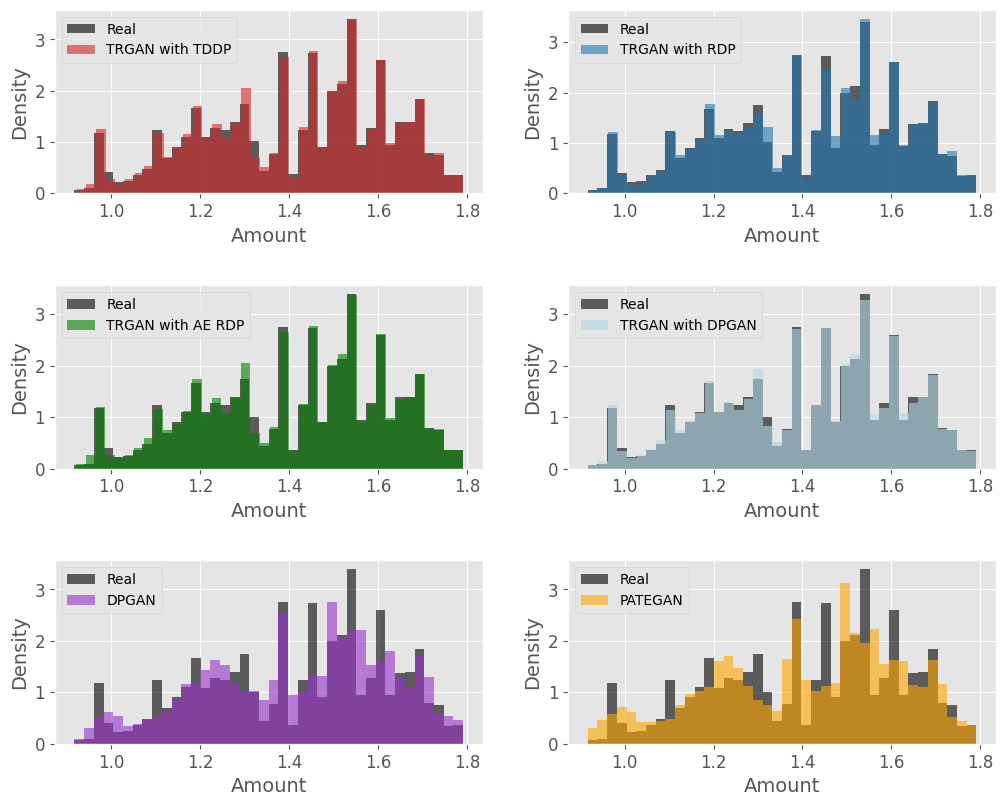

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8), dpi=100)


axs[0, 0].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[0, 0].hist(np.log1p(abs(synth_df['amount'])), bins=40, label='TRGAN with TDDP', alpha=0.6, color='tab:red', density=True)
axs[0, 0].set_xlabel('Amount')
axs[0, 0].set_ylabel('Density')
axs[0, 0].legend()

axs[0, 1].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[0, 1].hist(np.log1p(abs(synth_df_rdp['amount'])), bins=40, label='TRGAN with RDP', alpha=0.6, color='tab:blue', density=True)
axs[0, 1].set_xlabel('Amount')
axs[0, 1].set_ylabel('Density')
axs[0, 1].legend()

axs[1, 0].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[1, 0].hist(np.log1p(abs(synth_df_ae['amount'])), bins=40, label='TRGAN with AE RDP', alpha=0.6, color='green', density=True)
axs[1, 0].set_xlabel('Amount')
axs[1, 0].set_ylabel('Density')
axs[1, 0].legend()

axs[1, 1].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[1, 1].hist(np.log1p(abs(synth_df_trgan_dpgan['amount'])), bins=40, label='TRGAN with DPGAN', alpha=0.6, color='lightblue', density=True)
axs[1, 1].set_xlabel('Amount')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

axs[2, 0].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[2, 0].hist(np.log1p(abs(synth_df_dpgan['amount'])), bins=40, label='DPGAN', alpha=0.6, color='darkorchid', density=True)
axs[2, 0].set_xlabel('Amount')
axs[2, 0].set_ylabel('Density')
axs[2, 0].legend()

axs[2, 1].hist(np.log1p(abs(data['amount'])), bins=40, label='Real', alpha=0.6, color='black', density=True)
axs[2, 1].hist(np.log1p(abs(synth_df_pategan['amount'])), bins=40, label='PATEGAN', alpha=0.6, color='orange', density=True)
axs[2, 1].set_xlabel('Amount')
axs[2, 1].set_ylabel('Density')
axs[2, 1].legend()

plt.tight_layout(pad=0.5)
plt.subplots_adjust(hspace=0.50, wspace=0.20)
# plt.savefig('privacy_amount.pdf', dpi=300)
plt.show()

In [6]:
evaluate_numerical([data['amount'], synth_df['amount'], synth_df_rdp['amount'], synth_df_ae['amount'],\
                    synth_df_trgan_dpgan['amount'], synth_df_dpgan['amount'], synth_df_pategan['amount']],\
                    ['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE', 'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'])

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,3.202157,0.832387,-0.951807,-0.028051,0.000000,0.000000,0.000000
TRGAN with TDDP,3.205330,0.832787,-0.952207,-0.028733,0.000381,0.006448,0.003560
TRGAN with RDP-GAN,3.210400,0.832025,-0.947473,-0.028119,0.000681,0.012540,0.008489
TRGAN with DP AE,3.203981,0.833656,-0.951416,-0.030591,0.000377,0.006195,0.002877
TRGAN with DPGAN,3.198981,0.833123,-0.950738,-0.030508,0.000401,0.006127,0.003301
DPGAN,3.224998,0.834956,-0.921014,-0.031455,0.003281,0.032579,0.028708
PATEGAN,3.181954,0.841412,-0.912143,-0.044390,0.004752,0.032203,0.031842


In [7]:
contig_cols = ['customer', 'mcc']

evaluate_categorical([data['mcc'], synth_df['mcc'], synth_df_rdp['mcc'], synth_df_ae['mcc'],\
        synth_df_trgan_dpgan['mcc'], synth_df_dpgan['mcc'], synth_df_pategan['mcc']],\
        index=['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE', 'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'],\
        data_cont_array=[data[contig_cols], synth_df[contig_cols], synth_df_rdp[contig_cols],\
        synth_df_ae[contig_cols], synth_df_trgan_dpgan[contig_cols], synth_df_dpgan[contig_cols], synth_df_pategan[contig_cols]])

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.000000,1.000000,13.0,0.000000
TRGAN with TDDP,0.999133,0.675548,13.0,0.002905
TRGAN with RDP-GAN,0.998887,0.675609,13.0,0.003177
TRGAN with DP AE,0.999249,0.672372,13.0,0.002715
TRGAN with DPGAN,0.999536,0.677085,13.0,0.002185
DPGAN,0.548066,0.269539,13.0,0.053898
PATEGAN,0.284783,0.084897,13.0,0.059386


In [8]:
quasi_id = ['transaction_date']

pd.DataFrame(np.array([
    # [k_anonymity(data, quasi_id, 'mcc'), k_anonymity(synth_df, quasi_id, 'mcc'), k_anonymity(synth_df_rdp, quasi_id, 'mcc'),\
    #                     k_anonymity(synth_df_ae, quasi_id, 'mcc'), k_anonymity(synth_df_trgan_dpgan, quasi_id, 'mcc'), k_anonymity(synth_df_dpgan, quasi_id, 'mcc'),\
    #                     k_anonymity(synth_df_pategan, quasi_id, 'mcc')],\
    #                     [l_diversity(data, quasi_id, 'mcc'), l_diversity(synth_df, quasi_id, 'mcc'), l_diversity(synth_df_rdp, quasi_id, 'mcc'),
    #                      l_diversity(synth_df_ae, quasi_id, 'mcc'), l_diversity(synth_df_trgan_dpgan, quasi_id, 'mcc'), l_diversity(synth_df_dpgan, quasi_id, 'mcc'),
    #                      l_diversity(synth_df_pategan, quasi_id, 'mcc')],\
                        [t_closeness(data, quasi_id, 'amount'), t_closeness(synth_df, quasi_id, 'amount'), t_closeness(synth_df_rdp, quasi_id, 'amount'),\
                        t_closeness(synth_df_ae, quasi_id, 'amount'), t_closeness(synth_df_trgan_dpgan, quasi_id, 'amount'), t_closeness(synth_df_dpgan, quasi_id, 'amount'),
                        t_closeness(synth_df_pategan, quasi_id, 'amount')]]).T,\
                        # [l_diversity_cont(data, quasi_id, 'amount'), l_diversity_cont(synth_df, quasi_id, 'amount'), l_diversity_cont(synth_df_dpgan, quasi_id, 'amount')]]).T,\
            columns=['t-closeness'], index=['Real', 'TRGAN with TDDP', 'TRGAN with RDP-GAN', 'TRGAN with DP AE',\
            'TRGAN with DPGAN', 'DPGAN', 'PATEGAN'])

,t-closeness
Real,1.048541
TRGAN with TDDP,1.031266
TRGAN with RDP-GAN,1.034054
TRGAN with DP AE,1.034209
TRGAN with DPGAN,1.037046
DPGAN,1.024282
PATEGAN,1.020091
